## Honors Project - LING 3000Q
Prof. Stefan Kaufmann

Anna Kopec

4/21/2025

### Project Overview:
I completed all given excercises from ch. 18 in the Jurafsky and Martin textbook (to the best of my ability)
- **convert_to_cnf(grammar):** convert arbitrary grammars into CNF format
- **CKY(words, grammar):** given a sentence and corresponding grammar, parse all possible linguistic tree structures
- **PARSEVAL**: test CKY parser using data from Penn Treebank dataset and implement standard parse tree evaluator using PARSEVAL library


In [1]:
from nltk import CFG, Nonterminal, Production, Tree, induce_pcfg
import nltk
from collections import defaultdict
import random
import re
!pip install svgling
import svgling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00


### 18.1
Implement the algorithm to convert arbitrary context-free grammars to CNF. Apply your program to the L1 grammar

In [3]:
# copied grammar from textbook and added some addional productions for a larger grammar
L1_grammar = """
S -> NP VP
S -> Aux NP VP
NP -> Pronoun
NP -> Proper-Noun
NP -> Det Nominal
Nominal -> Noun
Nominal -> Nominal Noun
Nominal -> Nominal PP
VP -> Verb
VP -> Verb NP
VP -> Verb PP
VP -> Verb NP PP
PP -> Preposition NP

Aux -> 'will' | 'can' | 'should'
Verb -> 'book' | 'include' | 'prefer'
Pronoun -> 'I' | 'she' | 'me'
Proper-Noun -> 'United' | 'Houston'
Nominal -> 'book' | 'include' | 'prefer'
Noun -> 'book' | 'trip' | 'hotel'
Det -> 'the' | 'a'
Preposition -> 'in' | 'on' | 'of'
"""




In [6]:
def convert_to_CNF(grammar):
    '''This method converts an arbitrary grammar into Chomsky Normal Form by making sure that:
    -Each rule is binary, and if not, implement dummy non-terminals to make it binary
    -Terminals and non-terminals are not mixed together in rules
    Although usually CNF means no unit productions (NT->NT), I altered my parser algorithm to include unit productions.
    *method assumes that grammars don't have empty productions'''

    # store new CNF grammar here
    L2 = []

    # padding for dummy non-terminals
    padding = 'X'
    rule_count = 1

    # Build terminal-to-nonterminal mapping (for getting rid of mixed terminals/non-terminals later)
    terminal_map = defaultdict(list)
    for rule in grammar.productions():
        rhs = rule.rhs()
        if len(rhs) == 1 and isinstance(rhs[0], str):
            terminal_map[rhs[0]].append(rule.lhs())

    # check current rule, alter it to meet CNF criteria, then add it to new CNF grammar L2
    for rule in grammar.productions():
        lhs = rule.lhs()
        rhs = rule.rhs()

        # includes unit productions
        if len(rhs) == 1 and isinstance(rhs[0], Nonterminal):
            L2.append(Production(lhs, rhs))
            continue

        # Replace terminals with existing  NT categories (if part of a mixed rule)
        updated_rhs = []
        for sym in rhs:
            if isinstance(sym, str): # if dealing with T symbol
                if len(rhs) == 1:
                    updated_rhs.append(sym)  # keep terminals in rules like A → 'a'
                else: # mixed rule
                    if sym in terminal_map:
                        updated_rhs.append(terminal_map[sym][0])  # use the first corresponding NT category found
                    else:
                        # Optional: fallback to dummy nonterminal if terminal has no existing category
                        dummy_nt = Nonterminal(f'T_{sym}')
                        updated_rhs.append(dummy_nt)
                        L2.append(Production(dummy_nt, [sym]))
            else:
                updated_rhs.append(sym)

        # Binarize rules
        if len(updated_rhs) <= 2:
            L2.append(Production(lhs, updated_rhs))
        else:
            current_lhs = lhs
            for i in range(len(updated_rhs) - 2):
                dummy_nt = Nonterminal(f'{padding}{rule_count}')
                rule_count += 1
                L2.append(Production(current_lhs, [updated_rhs[i], dummy_nt]))
                current_lhs = dummy_nt
            L2.append(Production(current_lhs, updated_rhs[-2:]))

    return L2

In [7]:
L1 = CFG.fromstring(L1_grammar)
L2_grammar = convert_to_CNF(L1)
L2 = CFG(Nonterminal('S'), L2_grammar)

In [8]:
for rule in L2.productions():
    print(rule)

S -> NP VP
S -> Aux X1
X1 -> NP VP
NP -> Pronoun
NP -> Proper-Noun
NP -> Det Nominal
Nominal -> Noun
Nominal -> Nominal Noun
Nominal -> Nominal PP
VP -> Verb
VP -> Verb NP
VP -> Verb PP
VP -> Verb X2
X2 -> NP PP
PP -> Preposition NP
Aux -> 'will'
Aux -> 'can'
Aux -> 'should'
Verb -> 'book'
Verb -> 'include'
Verb -> 'prefer'
Pronoun -> 'I'
Pronoun -> 'she'
Pronoun -> 'me'
Proper-Noun -> 'United'
Proper-Noun -> 'Houston'
Nominal -> 'book'
Nominal -> 'include'
Nominal -> 'prefer'
Noun -> 'book'
Noun -> 'trip'
Noun -> 'hotel'
Det -> 'the'
Det -> 'a'
Preposition -> 'in'
Preposition -> 'on'
Preposition -> 'of'


### 18.2 + 18.3
 Implement the CKY algorithm and test it with your converted L1 grammar. +
Rewrite the CKY algorithm given in Fig. 18.12 on page 14 so that it can accept grammars that contain unit productions.

*For 18.3, inside of an additional "reformat" method, I implemented a dict that contains all corresponding Nonterminals for a given terminal. For each terminal, I found all possible unit production conversions (e.g. A -> B -> C). When initializing the CKY DP table with terminals, I added new leaves corresponding to each terminals' additional unit production conversions (e.g. (A->B) and (A->C)). under the corresponding terminal so that the algorithm would include all possible valid grammatical structures that could be derived from those unit productions.*

In [16]:
def reformat(grammar):
    '''extra method that allows CKY parser to process unit productions,
    convert grammar into a reversed dictionary for faster lookup,
    generate additional dictionary of just 1-to-1 maps for processing unit productions'''
    flipped = {}
    simple_map = {}
    single_mappings = {}

    # map each rhs to its corresponding lhs (reversed grammar mapping for easy lookup during parsing)
    for rule in grammar.productions():
        rhs = rule.rhs()
        lhs = rule.lhs()
        if rhs not in flipped:
            flipped[rhs] = set()
            flipped[rhs].add(lhs)

        #initialize dict to store all possible 1:1 conversions
        if len(rhs) == 1:
            if nltk.grammar.is_terminal(rhs):
                if rhs not in simple_map:
                    simple_map[rhs] = (lhs,)
                elif rhs in simple_map:
                    simple_map[rhs] += (lhs,)

    # initialize mapping of unit productions where all possible unit conversions for each terminal are explored and added
    for child in simple_map:
        if nltk.grammar.is_terminal(child[0]):
            parents = simple_map[child]
            single_mappings[child] = [parents[0]]
            for parent in parents:
                curr_parent = (parent,)
                while curr_parent in simple_map:
                   single_mappings[child].append(simple_map[curr_parent])
                   curr_parent = simple_map[curr_parent]

    return flipped, single_mappings




In [18]:
def CKY(words, grammar):
    '''Bottom-up diagonal CKY parser for CNF grammar, using nltk.Tree'''
    # pre-process given grammar (faster lookup, also allows CKY to handle unit productions)
    grammar, u_p = reformat(grammar)
    n = len(words)

    # setup n * n DP matrix
    table = [[[] for _ in range(n+1)] for _ in range(n)]

    # initialize table with terminals (A -> 'a')
    for i, word in enumerate(words):
        seen = set() # keep track of trees, eliminates duplicates
        if (word,) in grammar:
            for lhs in grammar[(word,)]:
                lhs_label = lhs[0] if isinstance(lhs, tuple) else lhs
                # store table containing 'parent' rule (lhs) and corresponding terminal (word)
                tree = Tree(lhs_label, [word])
                # key for keeping tack of trees being stored (memoization)
                key = (tree.label(), tuple(tree))
                if key not in seen:
                    table[i][i+1].append(tree)
                    seen.add(key)
            # fill cell of each terminal with all possible unit productions that can be extracted from its corresponding lhs(s)
            for lhs in u_p[(word,)]:
                lhs_label = lhs[0] if isinstance(lhs, tuple) else lhs
                tree = Tree(lhs_label, [word])
                key = (tree.label(), tuple(tree))
                if key not in seen:
                    table[i][i+1].append(tree)
                    seen.add(key)

    # Fill table with binary rules (A -> B C)
    # check all possible grammatical combinations across span num of trees
    for span in range(2, n+1):          # span length
        for i in range(n - span + 1):    # span start
            j = i + span                 # span end
            seen = set()
            for k in range(i+1, j):      # split point
                for left_tree in table[i][k]:
                    for right_tree in table[k][j]:
                        rhs_label = right_tree.label()
                        if isinstance(rhs_label, tuple):
                            rhs_label = rhs_label[0]
                        rhs = (left_tree.label(), rhs_label)
                        # see if combination of rules from left tree and right tree is valid (exists in grammar)
                        # if it is, add it to the DP table at i,j
                        if rhs in grammar:
                            for lhs in grammar[rhs]:
                                tree = Tree(lhs, [left_tree, right_tree])
                                key = (tree.label(), tuple(child if isinstance(child, str) else (child.label(),) for child in tree))
                                if key not in seen:
                                    table[i][j].append(tree)
                                    seen.add(key)
    # return last element of table (contains the possible parse tree(s) for entire sentence)
    return table[0][n]


In [21]:
# test sentence
words = ['I', 'book', 'the', 'trip', 'in', 'Houston']

In [22]:
g, p = reformat(L2)
parses=CKY(words, L2)

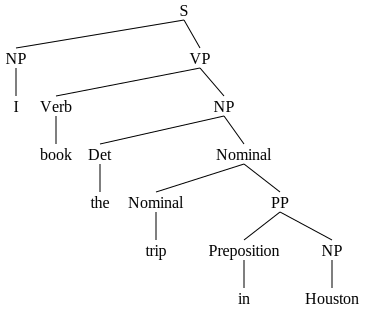

In [23]:
for parse in parses:
    display(parse)

### 18.4
Discuss how to augment a parser to deal with input that may be incorrect, for example, containing spelling errors or mistakes arising from automatic speech recognition.

*I think that a transformer model (or other neural networks capable of handling long sequences) would be highly beneficial for this specific task. Transformers can track long-range dependencies (important for understanding context in sentences), and they can be trained to process a high volume of linguistic data. In this situation, you could implement a transformer to identify if the sentence provided for parsing makes syntactic sense. After training the transformer on lots of grammatically and syntactically valid sentences, it could be trained to process a given sentence and provide a 'corrected' version of the sentence that makes more sense contextually. This will make it more likely that the parser will work correctly given noisy input.*

### 18.5
Implement the PARSEVAL metrics described in Section 18.8. Next, use a
parser and a treebank, compare your metrics against a standard implementation. Analyze the errors in your approach.

*The textbook was not very clear on how to implement a PARSEVAL algorithm besides providing definitions for the metrics themselves. I decided to simply implement the standard PARSEVAL evaluation tool "evalb" which unfortunately is rather outdated. Its documentation is not accurate, and both only inputs/outputs txt files, which is very difficult to do under the constraints of Colab and when trying to work with nltk Tree objects, not txt files or corpora.*

*I tested my CKY parser using the nltk treebank. I extracted grammars directly from these trees and plugged them into my alg alongside unlabelled sentences corresponding to the given grammar. My parser did not always give me a parse, and I am not completely sure why this is. However, when it did give me a parse and I was able to run the parse eval tool on it succesfully, I would get 100% accuracy.*

*My prediction for why my algorithm doesn't work all the time is that I only implement unit productions for the terminals and do not check them at every cell. For instance, if given a case where A and B have no unit productions, but C -> AB has a unit production C -> D, then D will be excluded and the parse could fail. I didn't implement this because finding all possible unit productions for any given NT/T is computationally expensive in its own right (this would be a recursive process unless some DP process that I am unaware of exists) and it would make the entire parser take even longer to run.*

run parser on treebank data:

In [24]:
from nltk.corpus import treebank
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [45]:
x = 0
y = x+1
trees = treebank.parsed_sents()[x:y]
productions = []
for tree in trees:
    tree.chomsky_normal_form(horzMarkov=2)
    productions += tree.productions()

S = Nonterminal('S')
cfg = CFG(S, productions)
sentences = treebank.sents()[x:y]

In [46]:
predictions = []
for i, sentence in enumerate(sentences):
    parses = CKY(sentence, cfg)
    predictions.append(parses)


PARSEVAL standard approach:

In [37]:
!pip install PYEVALB

In [38]:
from PYEVALB import scorer
from PYEVALB import parser
from PYEVALB import tree as pyevalb_tree_module
import tempfile

In [42]:
def score_bracket_strings(gold_bracket, pred_bracket):
    '''since pyevalb only works with txt files, I had to convert my predicted tree and gold standard trees into temporary txt files
    and then run the evalb alg on them'''
    result_path = tempfile.NamedTemporaryFile(delete=False).name
    s = scorer.Scorer()

    with tempfile.NamedTemporaryFile('w+', delete=False) as gold_file, \
         tempfile.NamedTemporaryFile('w+', delete=False) as pred_file, \
         tempfile.NamedTemporaryFile('w+', delete=False) as result_file:
        gold_file.write(gold_bracket)
        gold_file.flush()
        pred_file.write(pred_bracket)
        pred_file.flush()

        results = s.evalb(gold_file.name, pred_file.name, result_file.name)
        evalb_output = result_file.read()
    # outputs txt analysis of predicted vs gold standard parse trees computed using PARSEVAL metrics (recall, precision, crossing, accuracy)
    return evalb_output

In [48]:
# run PARSEVAL alg to compare predicted tree(s) by CKY parser vs. corresponding gold standard tree from treebank
results = []
for gold_tree in trees:
    gold_tree_reformatted = gold_tree.pformat(margin=1e10)
    for pred in predictions:
        if len(pred) == 0: continue
        for pred_tree in pred:
            pred_tree_reformatted = pred_tree.pformat(margin=1e10)
            if len(gold_tree_reformatted) == len(pred_tree_reformatted):
                r = score_bracket_strings(gold_tree_reformatted, pred_tree_reformatted)
                results.append(r)


In [50]:
results

['# Score Result\n| A | B | C | D | E | F | G | H | I | J | K | L |\n|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|\n|  0| 18|  0|  1|  1| 17| 17| 17|  0| 18| 18|  1|\n\n=================================================================================================================================================\nNumber of sentence:\t1.00\nNumber of Error sentence:\t0.00\nNumber of Skip  sentence:\t0.00\nNumber of Valid sentence:\t1.00\nBracketing Recall:\t100.00\nBracketing Precision:\t100.00\nBracketing FMeasure:\t100.00\nComplete match:\t100.00\nAverage crossing:\t0.00\nNo crossing:\t100.00\nTagging accuracy:\t100.00']